# Using cartopy and projections for plotting

In [1]:
import s3fs
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Open ERA5 dataset

In [9]:
# Importing the required packages
import intake
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt

## Reading and browsing the catalog

In [28]:
# Open the catalog

# col = intake.open_esm_datastore('https://storage.googleapis.com/cmip6/pangeo-cmip6.json') # Remote Pangeo

col = intake.open_esm_datastore('/mnt/craas1-ns9989k-geo4992/data/cmip6.json') # Local data stored on NIRD
col

,unique
variable_id,583
table_id,24
source_id,75
experiment_id,94
member_id,190
grid_label,11
time_range,9100
activity_id,18
institution_id,35
version,577


### Browsing the catalog: Compering the change in AOD over the historical period across CMIP6 models

The keywords when browsing is columns of the table.

In [30]:
col = col.search(
    experiment_id=['historical'],
    source_id=['CESM2'], 
    table_id=['Amon'],
    variable_id=['tas',], 
    member_id=['r1i1p1f1']
    
)


Models available for this request:

In [31]:
col.unique()['source_id']

['CESM2']

In [32]:
# dataset_dict = col.to_dataset_dict()
dataset_dict = col.to_dataset_dict(xarray_open_kwargs={'use_cftime':True, 'chunks':{'time':48}}, 
                           aggregate=True,
                               #preprocess=calculate_global_avg_and_resample,
                                   #skip_on_error=True,
                            xarray_combine_by_coords={'combine_attrs': 'override'}
                            
                          )



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [34]:
dset = dataset_dict['CMIP.NCAR']

## Get metadata 

In [35]:
dset

<xarray.Dataset> Size: 438MB
Dimensions:    (member_id: 1, time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 8B 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 438MB dask.array<chunksize=(1, 48, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) object 32kB dask.array<chunksize=(48, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float32 2kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 2kB dask.array<chunksize=(288, 2), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T23:34:05Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.NCAR

### Get variable metadata (air_temperature_at_2_metres)

In [36]:
dset['tas']

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 192, lon: 288)> Size: 438MB
dask.array<broadcast_to, shape=(1, 1980, 192, 288), dtype=float32, chunksize=(1, 48, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) object 8B 'r1i1p1f1'
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas

## Select time
- Check time format when selecting a specific time 

In [56]:

tas_plt = dset['tas'].sel(time=slice('2013-01-01','2014-01-01')).mean('time')-273.15
tas_plt.attrs['units'] ='deg C'

In [62]:
tas_plt = tas_plt.squeeze()

## Visualize data

### Simple visualization from xarray plotting method

CPU times: user 323 ms, sys: 27.9 ms, total: 351 ms
Wall time: 352 ms


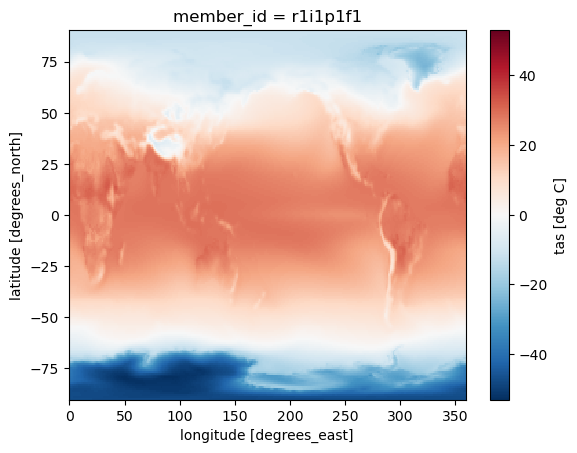

In [63]:
%%time 
tas_plt.load()
tas_plt.plot()#cmap = 'coolwarm')

#### Same plot but with local file

CPU times: user 22.7 ms, sys: 1.84 ms, total: 24.6 ms
Wall time: 23.8 ms


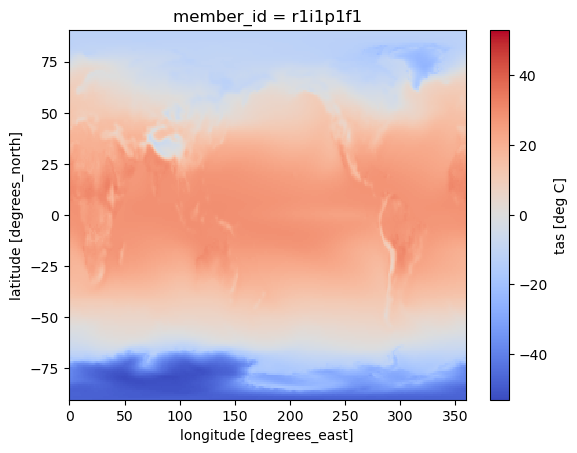

In [64]:
%%time 
tas_plt.plot(cmap = 'coolwarm')

### Customize plot

#### Set the size of the figure and add coastlines 

CPU times: user 402 ms, sys: 1.89 ms, total: 404 ms
Wall time: 405 ms


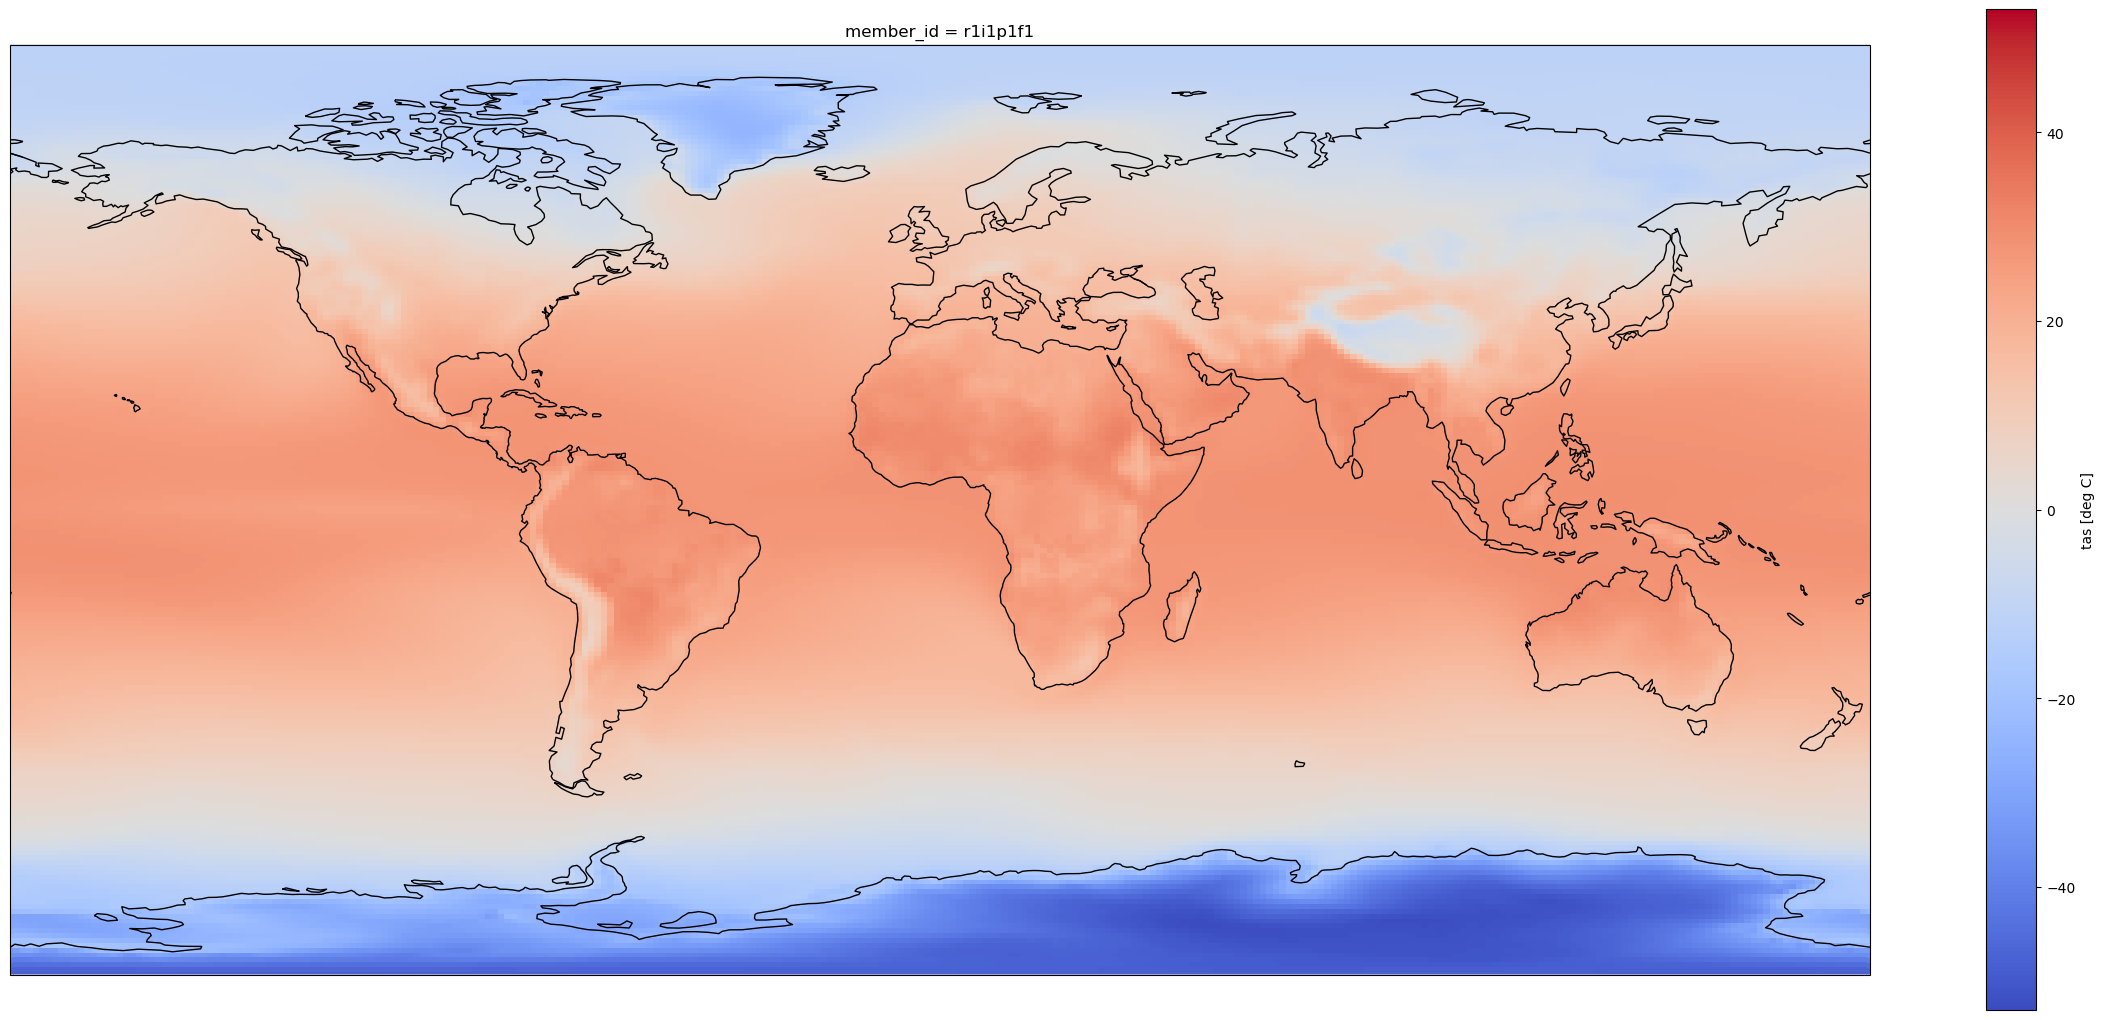

In [66]:
%%time
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
tas_plt.plot.pcolormesh(ax=ax, cmap='coolwarm')

#### Change plotting projection

CPU times: user 57.7 ms, sys: 4.09 ms, total: 61.8 ms
Wall time: 61.2 ms


Text(0.5, 1.0, 'CESM air temperature at 2 avg over 2013')

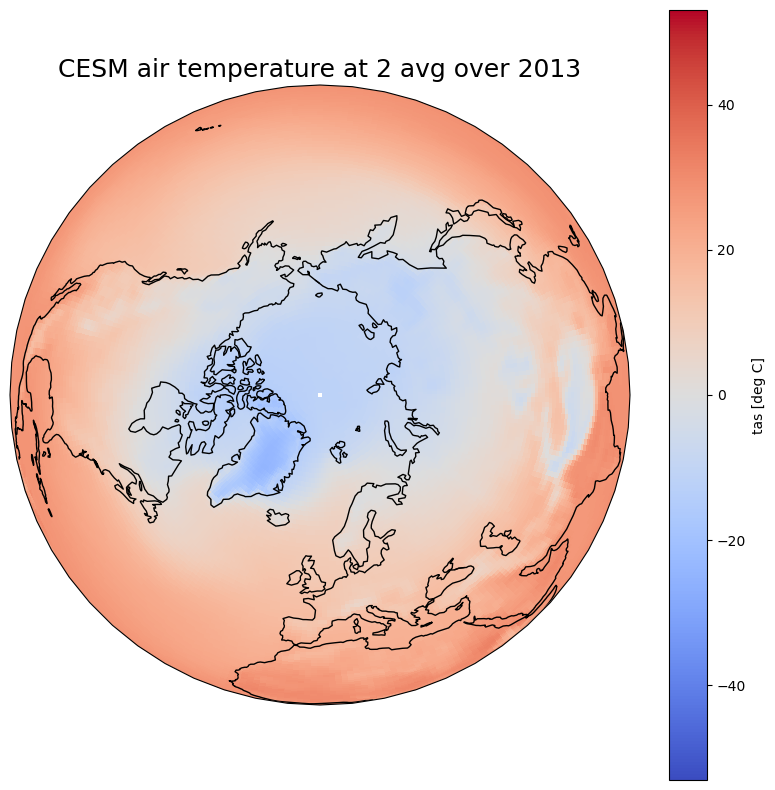

In [68]:
%%time

fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
tas_plt.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title("CESM air temperature at 2 avg over 2013", fontsize=18)

#### Choose extent of values

CPU times: user 53.2 ms, sys: 2.45 ms, total: 55.7 ms
Wall time: 54.9 ms


Text(0.5, 1.0, 'CESM air temperature at 2 avg over 2013')

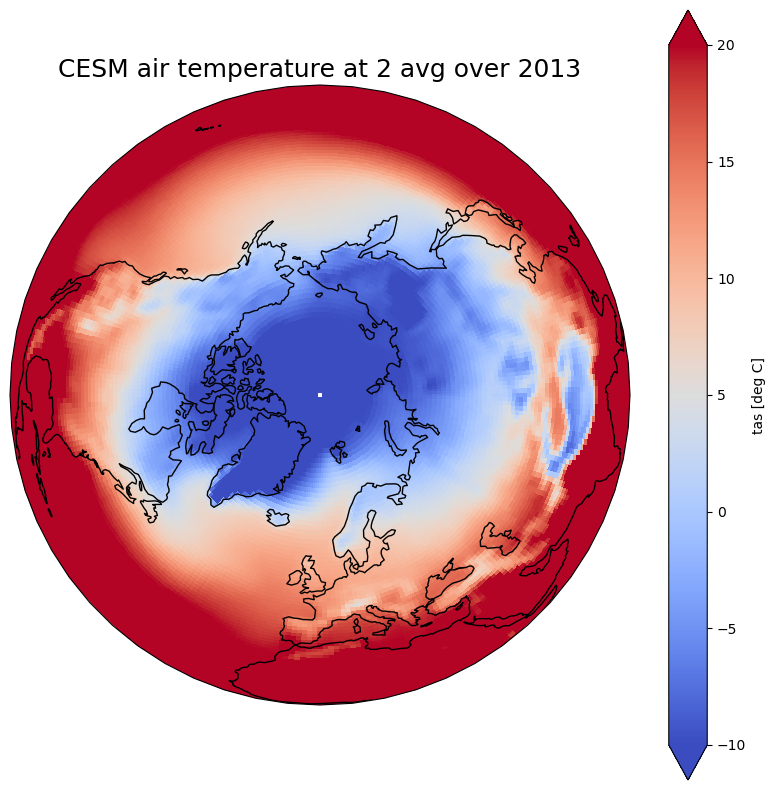

In [71]:
%%time
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = -10
maxval = 20

# pass extent with vmin and vmax parameters
tas_plt.plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
#plt.title("ERA5 air temperature at 2 metres\n 30th June 2020 at 21:00 UTC", fontsize=18)
plt.title("CESM air temperature at 2 avg over 2013", fontsize=18)


### Combine plots with different projections 

CPU times: user 98.4 ms, sys: 1.93 ms, total: 100 ms
Wall time: 99.6 ms


Text(0, 0.5, 'K')

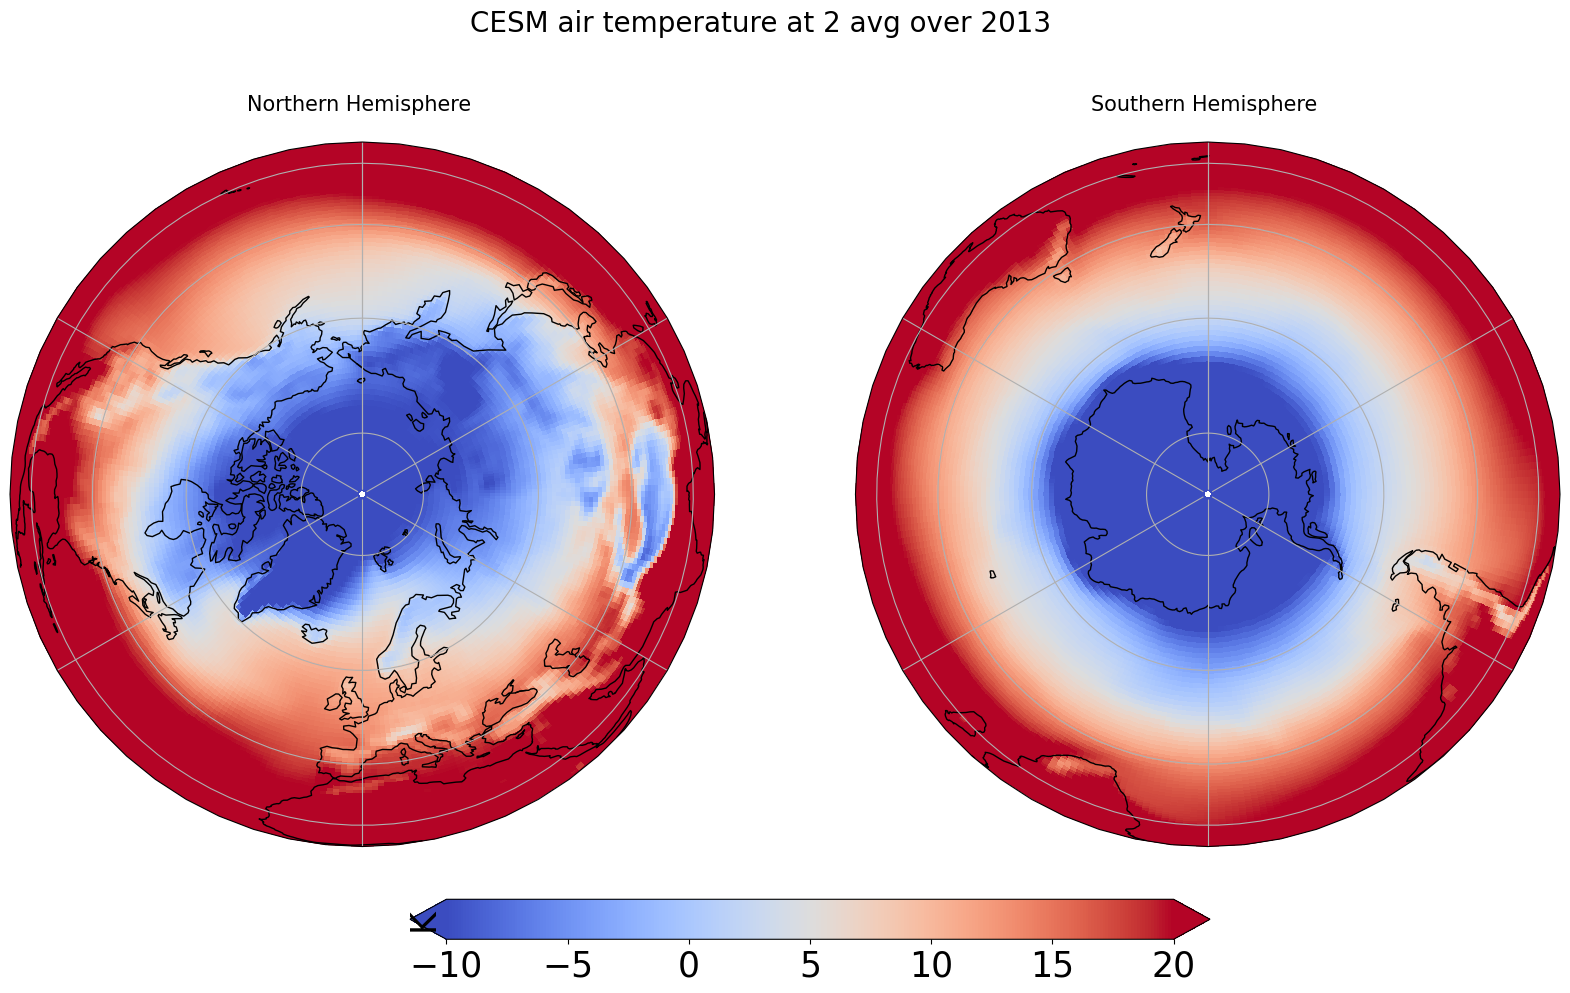

In [72]:
%%time
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = -10
maxval = 20

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 0
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = tas_plt.plot(ax=ax, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('CESM air temperature at 2 avg over 2013', fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)